In [1]:
renv::init('/oak/stanford/groups/agitler/Shared/Shared_Jupyter_Notebook_Analysis/4.1.1-OG/')

In [2]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(ggrepel)
library(pheatmap)
library(gplots)
library(svglite)
library(hdf5r)
library(DropletUtils)
library(scDblFinder)
library(scuttle)
library(scales)
library(ggrastr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRange

In [3]:
library(future)
plan("multicore", workers = availableCores())
options(future.globals.maxSize= +Inf)
# NotebookApp.max_buffer_size=214748364800
# hello world

## Custom Function

### Volcano plot

In [4]:
make_volcano_plot <- function(data, labeled_pts, labeled_genes=c(), p_val_cutoff=0.05, ylimits=NULL, xlimits=NULL, upper_log2FC_cutoff=0, lower_log2FC_cutoff=0) {
    data <- data %>% 
    mutate(
        Expression = case_when(avg_log2FC >= upper_log2FC_cutoff & p_val_adj <= p_val_cutoff ~ "Up-regulated",
                           avg_log2FC <= lower_log2FC_cutoff & p_val_adj <= p_val_cutoff ~ "Down-regulated",
                           TRUE ~ "Unchanged")
    )


    top <- labeled_pts
   
    top_genes <- bind_rows(
      data %>% 
        filter(Expression == 'Up-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(Expression == 'Down-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(gene %in% labeled_genes)
    )
    

    x_scale <- max(abs(data$avg_log2FC))
    
    p1 <- ggplot(data, aes(avg_log2FC, -log(p_val_adj,10))) + # -log10 conversion 
        geom_point(aes(color = Expression), size = 4/5) +
        geom_label_repel(data = top_genes, mapping = aes(avg_log2FC, -log(p_val_adj,10), label = gene),
                        size = 4, max.overlaps=18)+
        xlim(-x_scale,x_scale)+
        xlab(expression("Avg. log"[2]*"FC")) + 
        ylab(expression("-log"[10]*"(p adj)")) + 
        scale_color_manual(values = c("dodgerblue3", "gray50", "firebrick3")) + 
        guides(colour = guide_legend(override.aes = list(size=1.5)))  + 
        scale_y_continuous(limits = ylimits) +
        scale_x_continuous(limits = xlimits) +
        theme_classic() +
        theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15), plot.title = element_text(size = 18, face = "bold", hjust = 0.5))     
p1  
}

### File Loading and Saving Directories

In [5]:
load.dir <- '/oak/stanford/groups/agitler/Shared_Sequencing/Jacob/Levine-Human-FastQ/h5_files'
fig_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/Figure_Panels'
csv_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/CSV_Files'

## Identify low RNA/lncRNA/intronic read RNA profiles from Yadav et al.'s raw data

### Load H5 Matrices from Yadav 2022

In [ ]:
donor1_h5 <- Read10X_h5(paste(load.dir,'GSM5723843_Donor1_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor2_h5 <- Read10X_h5(paste(load.dir,'GSM5723844_Donor2_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor3_h5 <- Read10X_h5(paste(load.dir,'GSM5723845_Donor3_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor4_h5 <- Read10X_h5(paste(load.dir,'GSM5723846_Donor4_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor5_h5 <- Read10X_h5(paste(load.dir,'GSM5723847_Donor5_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor6_h5 <- Read10X_h5(paste(load.dir,'GSM5723848_Donor6_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)
donor7_h5 <- Read10X_h5(paste(load.dir,'GSM5723849_Donor7_raw_feature_bc_matrix.h5',sep='/'), use.names = TRUE, unique.features = TRUE)

In [6]:
bcrank1 <- barcodeRanks(donor1_h5)
bcrank2 <- barcodeRanks(donor2_h5)
bcrank3 <- barcodeRanks(donor3_h5)
bcrank4 <- barcodeRanks(donor4_h5)
bcrank5 <- barcodeRanks(donor5_h5)
bcrank6 <- barcodeRanks(donor6_h5)
bcrank7 <- barcodeRanks(donor7_h5)

In [7]:
low.intronic_donor1 <- donor1_h5[,donor1_h5['NEFH', ] >1 & bcrank1$total<2000 & bcrank1$total>100]
donor1.low.intronic.seurat <- CreateSeuratObject(low.intronic_donor1)

In [8]:
low.intronic_donor2 <- donor2_h5[,donor2_h5['NEFH', ] >1 & bcrank2$total<2000 & bcrank2$total>100]
donor2.low.intronic.seurat <- CreateSeuratObject(low.intronic_donor2)

In [9]:
low.intronic_donor3 <- donor3_h5[,donor3_h5['NEFH', ] >1 & bcrank3$total<2000 & bcrank3$total>100]
donor3.low.intronic.seurat <- CreateSeuratObject(low.intronic_donor3)

In [10]:
low.intronic_donor4 <- donor4_h5[,donor4_h5['NEFH', ] >1 & bcrank4$total<2000 & bcrank4$total>100]
donor4.low.intronic.seurat <- CreateSeuratObject(low.intronic_donor4)

In [11]:
low.intronic_donor5 <- donor5_h5[,donor5_h5['NEFH', ] >1 & bcrank5$total<2000 & bcrank5$total>100]
donor5.low.intronic.seurat <- CreateSeuratObject(low.intronic_donor5)

In [12]:
low.intronic_donor6 <- donor6_h5[,donor6_h5['NEFH', ] >1 & bcrank6$total<2000 & bcrank6$total>100]
donor6.low.intronic.seurat <- CreateSeuratObject(low.intronic_donor6)

In [13]:
low.intronic_donor7 <- donor7_h5[,donor7_h5['NEFH', ] >1 & bcrank7$total<2000 & bcrank7$total>100]
donor7.low.intronic.seurat <- CreateSeuratObject(low.intronic_donor7)

### Log Normalize list of Seurat Objects

In [14]:
normalize.aggregated.object <- function(experiment.aggregate) {
    library(Seurat)
    library(future)
    print("splitting complete")
    for (i in 1:length(x = experiment.aggregate)) {
        print(i)
        experiment.aggregate[[i]] <- NormalizeData(object = experiment.aggregate[[i]], 
            verbose = TRUE)
        print("normalization complete")
        experiment.aggregate[[i]] <- FindVariableFeatures(object = experiment.aggregate[[i]], 
            selection.method = "vst", nfeatures = 2000, verbose = TRUE)
        print("variable feature selection complete")
    }
    experiment.aggregate
}

In [15]:
find.pcs.and.clustids <- function (exp.data, pc.dims = 30, scale.data = TRUE, feature.list = NULL) 
{
    library(future)
    library(doParallel)
    if (scale.data == TRUE) {
        exp.data <- ScaleData(object = exp.data, verbose = TRUE)
    }
    exp.data <- RunPCA(object = exp.data, npcs = pc.dims, verbose = TRUE, 
        features = feature.list)
    exp.data <- RunUMAP(object = exp.data, reduction = "pca", 
        dims = 1:pc.dims)
    exp.data <- FindNeighbors(exp.data, dims = 1:pc.dims)
    exp.data <- FindClusters(exp.data, resolution = 0.5)
    exp.data
}

In [ ]:
low.intronic.objects.list <- c(donor1.low.intronic.seurat, donor2.low.intronic.seurat, donor3.low.intronic.seurat, donor4.low.intronic.seurat, donor5.low.intronic.seurat, donor6.low.intronic.seurat, donor7.low.intronic.seurat)
low.intronic.objects.list.normalized <- normalize.aggregated.object(low.intronic.objects.list)

### Remove Mitochondrial Reads

In [17]:
for(i in 1:length(low.intronic.objects.list.normalized)) {
    counts <- GetAssayData(low.intronic.objects.list.normalized[[i]], assay = "RNA")
    mito_genes <- grep( "^MT-", rownames(low.intronic.objects.list.normalized[[i]]), value = T)
    counts <- counts[-(which(rownames(counts) %in% mito_genes)),]
    low.intronic.objects.list.normalized[[i]] <- subset(low.intronic.objects.list.normalized[[i]], features = rownames(counts))
    
}

### Find Variable Features etc

In [ ]:
for(i in 1:length(low.intronic.objects.list.normalized)) {
    DefaultAssay(low.intronic.objects.list.normalized[[i]]) <- 'RNA'
    low.intronic.objects.list.normalized[[i]] <- FindVariableFeatures(low.intronic.objects.list.normalized[[i]])
    low.intronic.objects.list.normalized[[i]] <- find.pcs.and.clustids(low.intronic.objects.list.normalized[[i]])
    
}

### Integrate Across Datasets

In [ ]:
low.intronic.droplets.anchors <- FindIntegrationAnchors(object.list = low.intronic.objects.list.normalized, )


In [ ]:
low.intronic.droplets.integrated <- IntegrateData(anchorset = low.intronic.droplets.anchors, verbose=T)


In [ ]:
DefaultAssay(low.intronic.droplets.integrated) <- 'RNA'
low.intronic.droplets.integrated <- FindVariableFeatures(low.intronic.droplets.integrated)
low.intronic.droplets.integrated <- find.pcs.and.clustids(low.intronic.droplets.integrated)

### Based on expression of NEAT1 and NEFM, Clusters 2, 3, and 5 are neuronal low intronic read profiles

In [23]:
DefaultAssay(low.intronic.droplets.integrated) <- 'integrated'
low.intronic.droplets.integrated.final <- subset(low.intronic.droplets.integrated, idents=c(2,3,5))

In [ ]:
DefaultAssay(low.intronic.droplets.integrated) <- 'RNA'
low.intronic.droplets.integrated.final <- FindVariableFeatures(low.intronic.droplets.integrated.final)
low.intronic.droplets.integrated.final <- find.pcs.and.clustids(low.intronic.droplets.integrated.final)

### Based on reclustering and NEAT1/NEFM expression, clusters 0,1,2 are neuronal low intronic read profiles

In [25]:
DefaultAssay(low.intronic.droplets.integrated.final) <- 'integrated'
low.intronic.droplets.integrated.neuronal <- subset(low.intronic.droplets.integrated.final, idents=c(0,1,2))

In [ ]:
low.intronic.droplets.integrated.neuronal <- FindVariableFeatures(low.intronic.droplets.integrated.neuronal)
low.intronic.droplets.integrated.neuronal <- RunPCA(low.intronic.droplets.integrated.neuronal)


In [ ]:
low.intronic.droplets.integrated.neuronal <- FindNeighbors(low.intronic.droplets.integrated.neuronal, dims = 1:20)
low.intronic.droplets.integrated.neuronal <- FindClusters(low.intronic.droplets.integrated.neuronal, resolution = 2)

In [ ]:
low.intronic.droplets.integrated.neuronal <- RunUMAP(low.intronic.droplets.integrated.neuronal, dims = 1:20)

In [ ]:
saveRDS(low.intronic.droplets.integrated.neuronal, file= '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/low.intronic.droplets.integrated.neuronal.RDS')

## Confirm that all RNA profiles have a low proportion of intronic reads

### Get barcodes by orig.ident

In [6]:
low.intronic.droplets.integrated.neuronal <- readRDS(file= '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/low.intronic.droplets.integrated.neuronal.RDS')

In [7]:
droplets.prop.intronic <- low.intronic.droplets.integrated.neuronal

In [8]:
droplets.prop.intronic$barcode <- rownames(droplets.prop.intronic@meta.data)
droplets.prop.intronic@meta.data <- droplets.prop.intronic@meta.data %>% mutate(barcode = stringr::str_remove(barcode, "_.+"))

droplets.prop.intronic$orig.donor <- rownames(droplets.prop.intronic@meta.data)
droplets.prop.intronic@meta.data <- droplets.prop.intronic@meta.data %>% mutate(orig.donor = stringr::str_remove(orig.donor, ".*_"))

In [9]:
H1_barcodes <- droplets.prop.intronic@meta.data %>% dplyr::filter(orig.donor == "1") %>% dplyr::select(barcode)
H1_barcodes$orig.barcode <- rownames(H1_barcodes)

In [10]:
H4_barcodes <- droplets.prop.intronic@meta.data %>% dplyr::filter(orig.donor == "2") %>% dplyr::select(barcode)
H4_barcodes$orig.barcode <- rownames(H4_barcodes)

In [11]:
H5_barcodes <- droplets.prop.intronic@meta.data %>% dplyr::filter(orig.donor == "3") %>% dplyr::select(barcode)
H5_barcodes$orig.barcode <- rownames(H5_barcodes)

In [12]:
H6B_barcodes <- droplets.prop.intronic@meta.data %>% dplyr::filter(orig.donor == "4") %>% dplyr::select(barcode)
H6B_barcodes$orig.barcode <- rownames(H6B_barcodes)

In [13]:
H7B_barcodes <- droplets.prop.intronic@meta.data %>% dplyr::filter(orig.donor == "5") %>% dplyr::select(barcode)
H7B_barcodes$orig.barcode <- rownames(H7B_barcodes)

In [14]:
# No RNA profiles from donor H7B
H7B_barcodes

barcode,orig.barcode
<chr>,<chr>


In [15]:
Tsai1B_barcodes <- droplets.prop.intronic@meta.data %>% dplyr::filter(orig.donor == "6") %>% dplyr::select(barcode)
Tsai1B_barcodes$orig.barcode <- rownames(Tsai1B_barcodes)

In [16]:
Tsai2_barcodes <- droplets.prop.intronic@meta.data %>% dplyr::filter(orig.donor == "7") %>% dplyr::select(barcode)
Tsai2_barcodes$orig.barcode <- rownames(Tsai2_barcodes)

### Load data analyzed with and without including intronic reads

In [17]:
H1_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H1_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H1_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H1_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [18]:
H4_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H4_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H4_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H4_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [19]:
H5_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H5_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H5_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H5_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [20]:
H6B_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H6B_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H6B_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H6B_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [21]:
Tsai1B_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai1B_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
Tsai1B_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai1B_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [22]:
Tsai2_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai2_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
Tsai2_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai2_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

### Function to get prop of intronic reads

In [23]:
get_prop_intronic <- function(with_introns, without_introns, barcodes){

    with_introns_all <- subset(with_introns, cells = barcodes$barcode)
    with_introns_all$barcode <- rownames(with_introns_all@meta.data)
    
    without_introns_all <- subset(without_introns, cells = barcodes$barcode)
    without_introns_all$barcode <- rownames(without_introns_all@meta.data)
    
    prop.intronic <- inner_join(with_introns_all@meta.data, without_introns_all@meta.data, by = "barcode")
    prop.intronic$prop_intronic <- (prop.intronic$nCount_RNA.x - prop.intronic$nCount_RNA.y)/prop.intronic$nCount_RNA.x
    prop.intronic <- inner_join(prop.intronic, barcodes, by = "barcode")
    rownames(prop.intronic) <- prop.intronic$orig.barcode
    prop.intronic <- dplyr::select(prop.intronic, prop_intronic)

return(prop.intronic)
}

In [24]:
H1_prop_intronic <- get_prop_intronic(H1_with_introns, H1_without_introns, H1_barcodes)
H4_prop_intronic <- get_prop_intronic(H4_with_introns, H4_without_introns, H4_barcodes)
H5_prop_intronic <- get_prop_intronic(H5_with_introns, H5_without_introns, H5_barcodes)
H6B_prop_intronic <- get_prop_intronic(H6B_with_introns, H6B_without_introns, H6B_barcodes)
Tsai1B_prop_intronic <- get_prop_intronic(Tsai1B_with_introns, Tsai1B_without_introns, Tsai1B_barcodes)
Tsai2_prop_intronic <- get_prop_intronic(Tsai2_with_introns, Tsai2_without_introns, Tsai2_barcodes)

In [25]:
prop_intronic_combo <- dplyr::bind_rows(H1_prop_intronic, H4_prop_intronic) %>% dplyr::bind_rows(H5_prop_intronic) %>% dplyr::bind_rows(H6B_prop_intronic) %>% dplyr::bind_rows(Tsai1B_prop_intronic) %>% dplyr::bind_rows(Tsai2_prop_intronic)

In [26]:
droplets.prop.intronic <- AddMetaData(droplets.prop.intronic, prop_intronic_combo)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 19 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 19 rows containing non-finite values (stat_summary).”


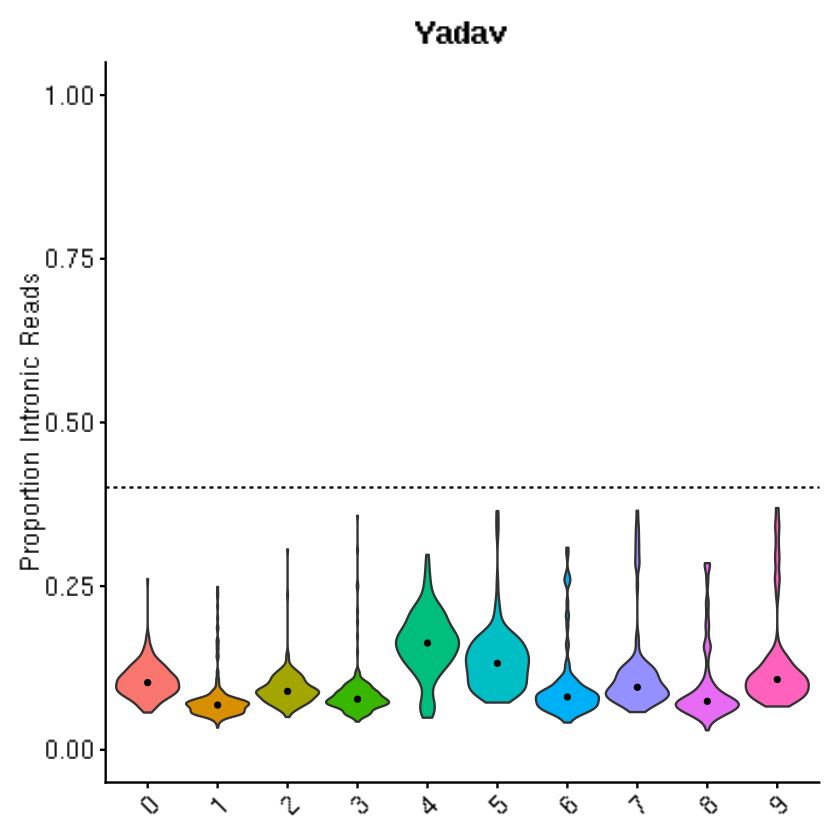

In [27]:
droplets_intronic <- VlnPlot(droplets.prop.intronic, features = "prop_intronic", pt.size = 0) + 
  labs(title = "Yadav", y = "Proportion Intronic Reads") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,1)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank()) & geom_hline(linetype = "dashed", yintercept = 0.4)

droplets_intronic

In [28]:
saveRDS(droplets.prop.intronic, file= '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/droplets.prop.intronic.RDS')


## Figure S1A'

In [29]:
low.intronic.droplets.integrated.neuronal <- readRDS(file= '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/low.intronic.droplets.integrated.neuronal.RDS')


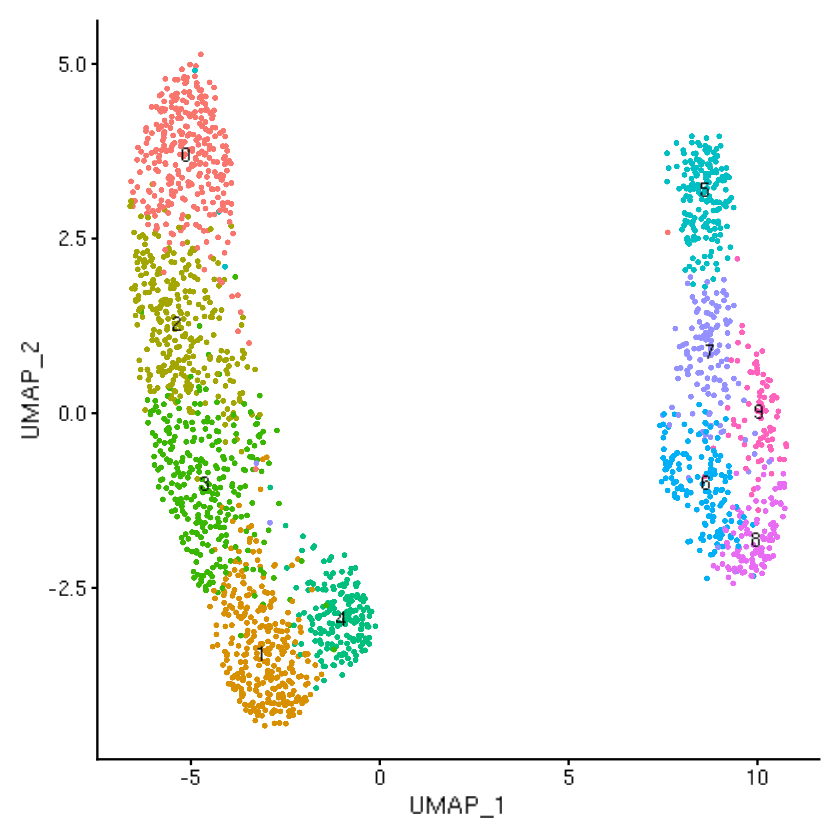

In [30]:
DefaultAssay(low.intronic.droplets.integrated.neuronal) <- 'RNA'

low.intronic_UMAP <- DimPlot(low.intronic.droplets.integrated.neuronal, reduction = "umap", label = TRUE) + NoLegend()
low.intronic_UMAP <- rasterize(low.intronic_UMAP, layers='Point', dpi=500)
low.intronic_UMAP

In [31]:
ggsave(low.intronic_UMAP, filename = paste(fig_dir, 'Reviews/low.intronic_UMAP.svg', sep='/'), device='svg', width = 2.6, height = 2.6, units = "in")

## Figure S1B'

In [32]:
droplets.mod <- low.intronic.droplets.integrated.neuronal

In [33]:
raw_counts <- as.data.frame(droplets.mod$RNA@counts)

In [34]:
SLC17A6_SLC6A5_counts <- raw_counts %>%
  filter(rownames(.) %in% c("SLC17A6", "SLC6A5")) %>%
  summarise(across(everything(), sum)) %>% t()

In [35]:
droplets.mod$SLC17A6_SLC6A5_counts <- SLC17A6_SLC6A5_counts

In [36]:
droplets.mod@meta.data <- droplets.mod@meta.data %>%
  mutate(SLC17A6_SLC6A5_lognorm = log((SLC17A6_SLC6A5_counts / nCount_RNA) * 10000 + 1))

### Top

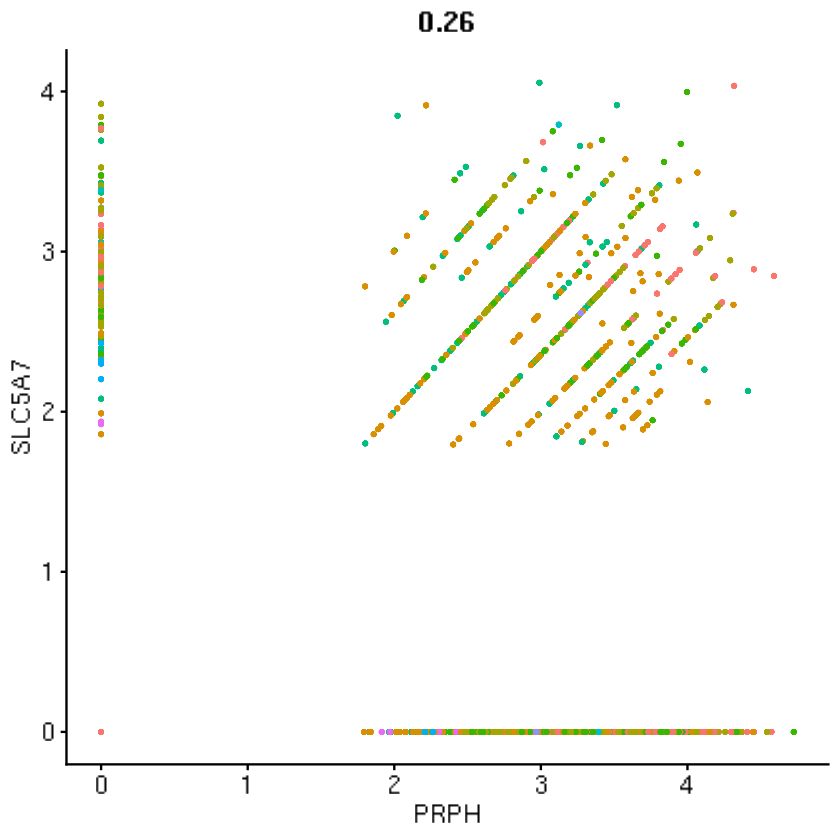

In [37]:
PRPH_SLC5A7_scatter <- FeatureScatter(droplets.mod, pt.size= 1, feature1="PRPH", feature2="SLC5A7")
PRPH_SLC5A7_scatter <- rasterize(PRPH_SLC5A7_scatter, layer= 'Point', dpi=500) +
    NoLegend() + FontSize(x.title=14.66, y.title=14.66, x.text=14.66, y.text=14.66) 

PRPH_SLC5A7_scatter

### Middle

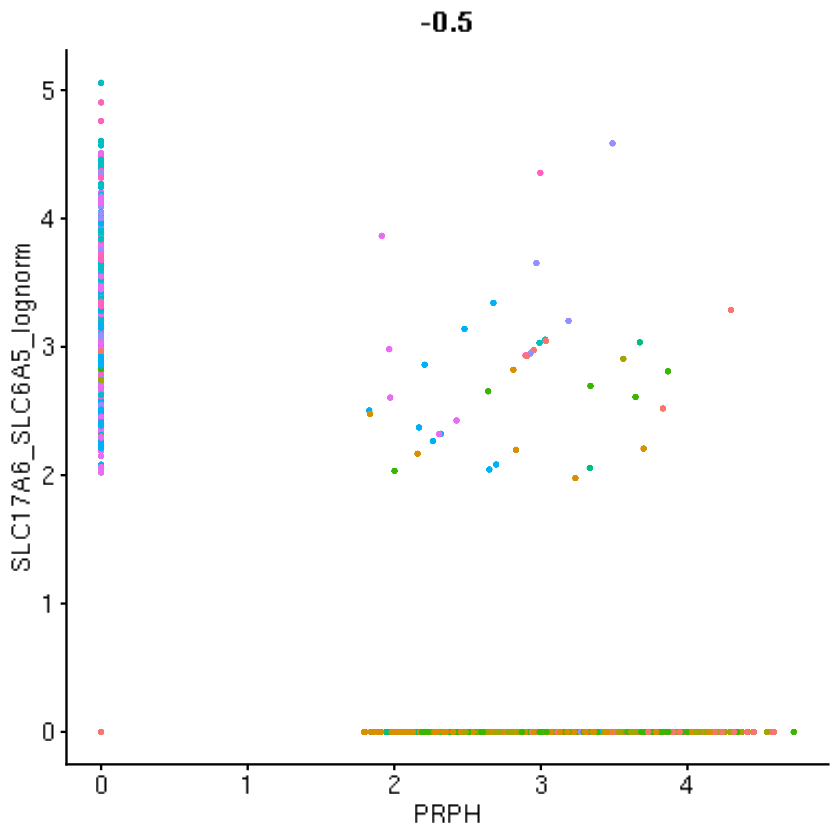

In [38]:
PRPH_SLC17A6_SLC6A5_scatter <- FeatureScatter(droplets.mod, pt.size= 1, feature1="PRPH", feature2="SLC17A6_SLC6A5_lognorm")
PRPH_SLC17A6_SLC6A5_scatter <- rasterize(PRPH_SLC17A6_SLC6A5_scatter, layer= 'Point', dpi=500) +
    NoLegend() + FontSize(x.title=14.66, y.title=14.66, x.text=14.66, y.text=14.66) 

PRPH_SLC17A6_SLC6A5_scatter

### Bottom

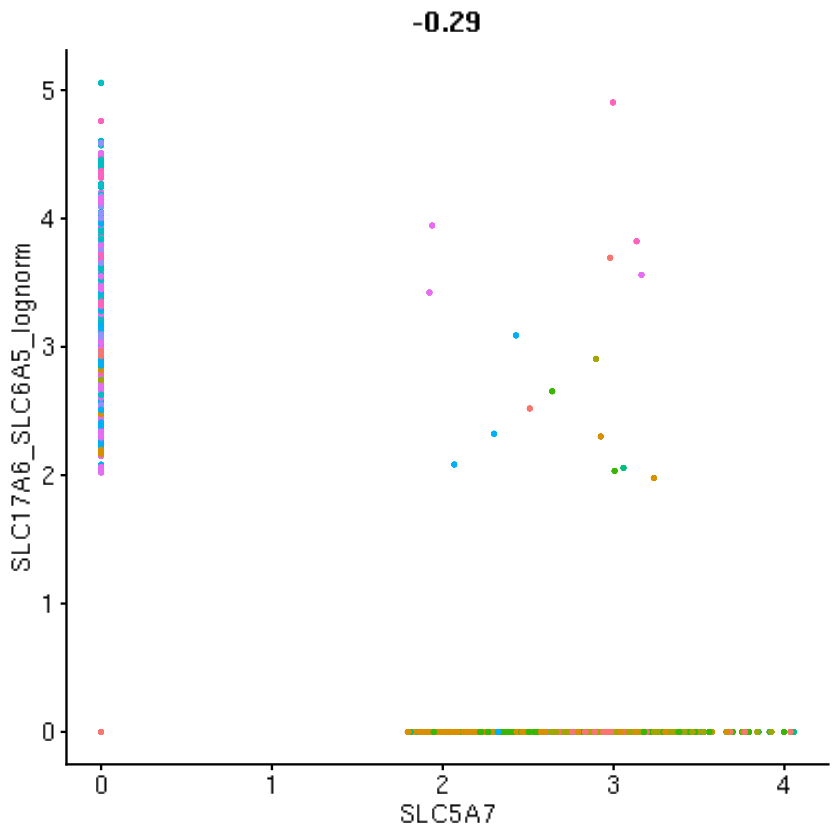

In [39]:
SLC5A7_SLC17A6_SLC6A5_scatter <- FeatureScatter(droplets.mod, pt.size= 1, feature1="SLC5A7", feature2="SLC17A6_SLC6A5_lognorm")
SLC5A7_SLC17A6_SLC6A5_scatter <- rasterize(SLC5A7_SLC17A6_SLC6A5_scatter, layer= 'Point', dpi=500) +
    NoLegend() + FontSize(x.title=14.66, y.title=14.66, x.text=14.66, y.text=14.66) 

SLC5A7_SLC17A6_SLC6A5_scatter

In [40]:
ggsave(filename = paste(fig_dir,'Reviews/PRPH_SLC5A7_scatter.svg', sep='/'),
       plot= PRPH_SLC5A7_scatter, device = 'svg', width=2, height=2.18, unit= 'in')

In [41]:
ggsave(filename = paste(fig_dir,'Reviews/PRPH_SLC17A6_SLC6A5_scatter.svg', sep='/'),
       plot= PRPH_SLC17A6_SLC6A5_scatter, device = 'svg', width=2, height=2.18, unit= 'in')

In [42]:
ggsave(filename = paste(fig_dir,'Reviews/SLC5A7_SLC17A6_SLC6A5_scatter.svg', sep='/'),
       plot= SLC5A7_SLC17A6_SLC6A5_scatter, device = 'svg', width=2, height=2.18, unit= 'in')

## Figure S1C'


In [43]:
neuronal.low.intronic.exp.mat <- AverageExpression(low.intronic.droplets.integrated.neuronal, assays = 'RNA')$RNA

In [44]:
marker.heatmap <- neuronal.low.intronic.exp.mat[c('SLC5A7', 'SLC17A6', 
                                    'SLC6A5', 'GAD1', 'PRPH','GAD2'),]

In [45]:
marker.heatmap <- (marker.heatmap - rowMins(marker.heatmap))/(rowMaxs(marker.heatmap) - rowMins(marker.heatmap))

In [46]:
neuronal_low_intronic_subclustering_heatmap <- 
    pheatmap(marker.heatmap, cluster_rows = TRUE, cluster_cols = TRUE, 
             filename = paste(fig_dir, 'Reviews/neuronal_low.intronic_subclustering_heatmap2.pdf', sep='/'),
             cellwidth = 40, cellheight = 48,
             width = 10, height = 10, fontsize = 27) 

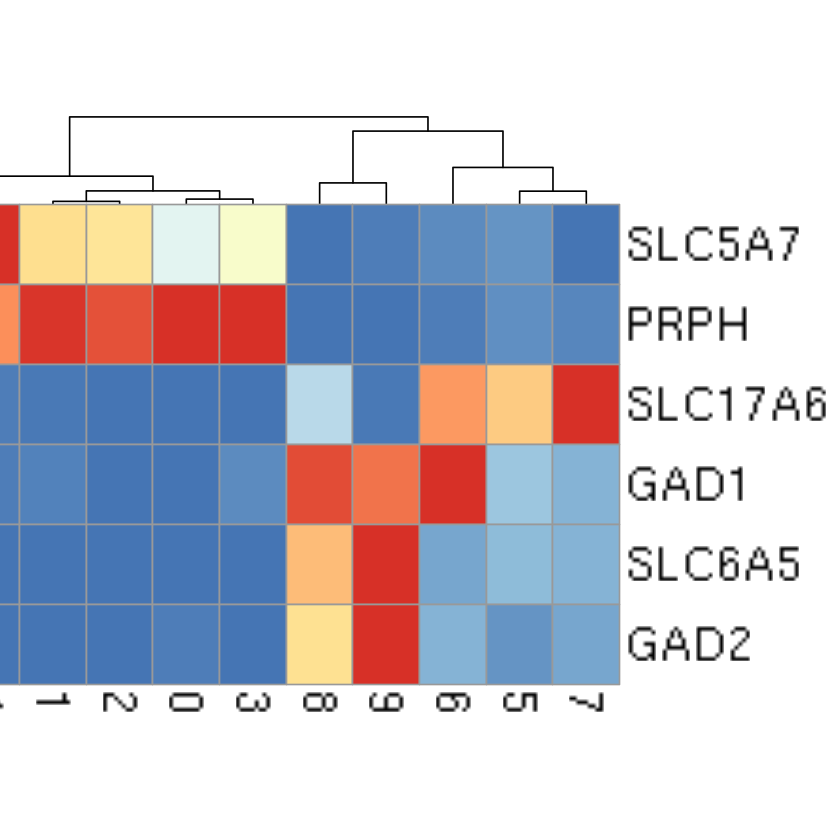

In [47]:
neuronal_low_intronic_subclustering_heatmap

## Figure S1D'

In [48]:
# Get low intronic read profiles from glutamatergic neurons
glutamate_low_intronic <- subset(low.intronic.droplets.integrated.neuronal, SLC17A6 > 0 & GAD1 == 0 & SLC6A5 == 0 & SLC5A7 == 0)

In [49]:
glutamate_low_intronic

An object of class Seurat 
35525 features across 191 samples within 2 assays 
Active assay: RNA (33525 features, 2000 variable features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [50]:
# Get low intronic read profiles from GABA/glycinergic neurons
inhibitory_low_intronic <- subset(low.intronic.droplets.integrated.neuronal, (GAD1 > 0 | SLC6A5 > 0) & SLC17A6 == 0 & SLC5A7 == 0)

In [51]:
inhibitory_low_intronic

An object of class Seurat 
35525 features across 241 samples within 2 assays 
Active assay: RNA (33525 features, 2000 variable features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [52]:
# Get other neuron (non-motor neuron) profiles from Yadav et al. final dataset
yadav_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')

In [53]:
yadav_other <- subset(yadav_neurons, subset = motor_neuron == "Other Neurons")

In [54]:
yadav_other

An object of class Seurat 
44058 features across 1822 samples within 3 assays 
Active assay: RNA (22238 features, 0 variable features)
 2 other assays present: SCT, integrated
 2 dimensional reductions calculated: pca, umap

### Volcano plot (glutamatergic low intronic read profiles vs. Yadav other neurons)

In [55]:
glutamate_yadav <- merge(yadav_other, glutamate_low_intronic)

Warning message:
“Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects.”
Warning message:
“Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects.”


In [56]:
glutamate_yadav <- NormalizeData(glutamate_yadav)

In [57]:
glutamate_yadav$low.intronic <- ifelse(glutamate_yadav$motor_neuron == "Other Neurons" & !is.na(glutamate_yadav$motor_neuron), yes = "Other Neurons", no = "low.intronic")
Idents(glutamate_yadav) <- glutamate_yadav$low.intronic
glutamate_markers <- FindMarkers(glutamate_yadav, ident.1 = "low.intronic", ident.2 = "Other Neurons", logfc.threshold=0, min.pct=0)

### Table S1K (related to Figure S1D', left)

In [58]:
write.csv(glutamate_markers, file=paste(csv_dir, 'Reviews/Table S1K.csv', sep='/'))

### Figure S1D' (left)

In [59]:
glutamate_markers$gene <- rownames(glutamate_markers)
rownames(glutamate_markers) <- NULL

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



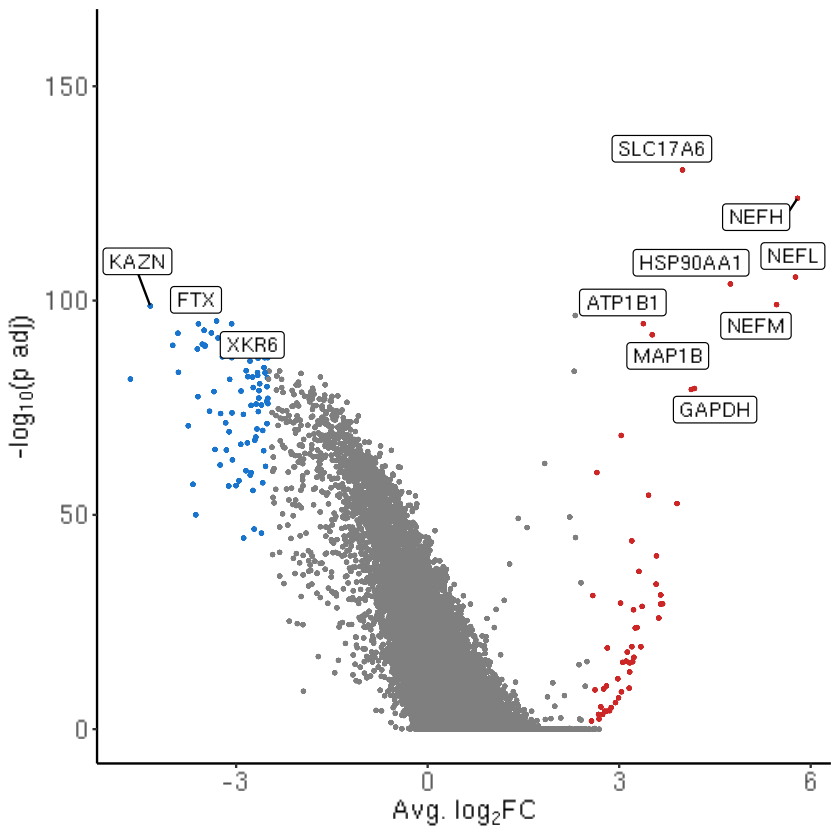

In [60]:
glutamate_volcano_plot <- make_volcano_plot(glutamate_markers, 3, p_val_cutoff = 0.05, labeled_genes=c("HSP90AA1","NEFM","ATP1B1","MAP1B","GAPDH"), ylimits=c(0,160), upper_log2FC_cutoff=2.5, lower_log2FC_cutoff=-2.5)
glutamate_volcano_plot <- rasterize(glutamate_volcano_plot, layers="Point", dpi=500) + NoLegend()
glutamate_volcano_plot

In [61]:
ggsave(glutamate_volcano_plot, filename = paste(fig_dir, 'Reviews/glutamate_volcano_plot.svg', sep='/'), device='svg', width = 3.3884, height = 2.8356, units = "in")

### Volcano plot (GABA/glycinergic low intronic read profiles vs. Yadav other neurons)

In [62]:
inhibitory_yadav <- merge(yadav_other, inhibitory_low_intronic)
inhibitory_yadav <- NormalizeData(inhibitory_yadav)

Warning message:
“Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects.”
Warning message:
“Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects.”


In [63]:
inhibitory_yadav$low.intronic <- ifelse(inhibitory_yadav$motor_neuron == "Other Neurons" & !is.na(inhibitory_yadav$motor_neuron), yes = "Other Neurons", no = "low.intronic")
Idents(inhibitory_yadav) <- inhibitory_yadav$low.intronic
inhibitory_markers <- FindMarkers(inhibitory_yadav, ident.1 = "low.intronic", ident.2 = "Other Neurons", logfc.threshold=0, min.pct=0)

### Table S1L (related to Figure S1D', right)

In [64]:
write.csv(inhibitory_markers, file=paste(csv_dir, 'Reviews/Table S1L.csv', sep='/'))

### Figure S1D' (right)

In [65]:
inhibitory_markers$gene <- rownames(inhibitory_markers)
rownames(inhibitory_markers) <- NULL

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



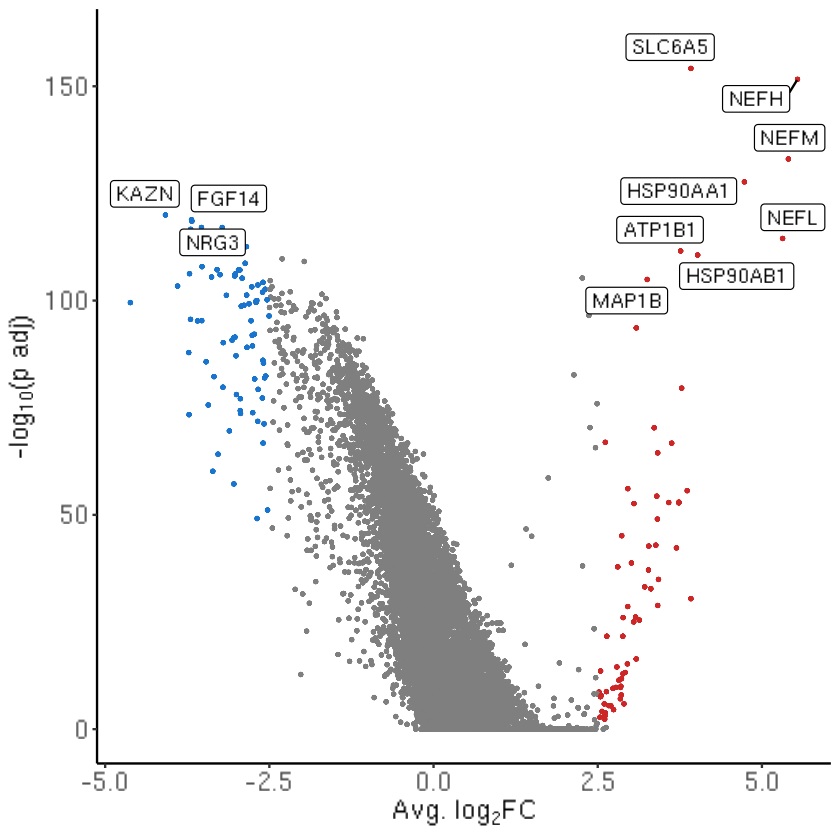

In [66]:
inhibitory_volcano_plot <- make_volcano_plot(inhibitory_markers, 3, p_val_cutoff = 0.05, labeled_genes=c("HSP90AA1","NEFL","ATP1B1","HSP90AB1","MAP1B"), ylimits=c(0,160), upper_log2FC_cutoff=2.5, lower_log2FC_cutoff=-2.5)
inhibitory_volcano_plot <- rasterize(inhibitory_volcano_plot, layers="Point", dpi=500) + NoLegend()
inhibitory_volcano_plot

In [67]:
ggsave(inhibitory_volcano_plot, filename = paste(fig_dir, 'Reviews/inhibitory_volcano_plot.svg', sep='/'), device='svg', width = 3.3884, height = 2.8356, units = "in")